In [1]:
#Import librarys for data manipulation and Neural Network

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Activation, Dropout, Dense, LeakyReLU, Softmax, BatchNormalization
from tensorflow.keras import Sequential

import matplotlib.pyplot as plt

import time
import joblib

In [2]:
#Read in pitching history
df=pd.read_csv('Bieber.csv')
team='CLE'

columns=list(df.columns)
df=df.fillna('')

In [3]:
#In game pitch count not tracked
df_test=pd.DataFrame()

#cumulative pitches, will match df length
#source df has last pitch thrown listed first
#need to subtract pitches tallied in df from total pitches to get pitches thrown in game
pitches=[]

#In game pitch count not tracked - cumulative pitches at time of current pitch
pitch_count={}

for i, row in df.iterrows():
    date=row['game_date']
    
    #get toal pitches for given game
    game_total=df.groupby('game_date')['pitch_type'].count()[date]
    
    #use date as key, tally each occurence of a date to tally pitches
    pitch_count[date]=pitch_count.get(date,0)+1
    
    pitches.append(game_total-pitch_count[date])

pitches=np.array(pitches)    

df_inputs = pd.DataFrame()
df_inputs['pitchcount']=pitches.tolist()    

In [4]:
#Copy some features directly from source df
#balls, strikes indicate the count
#outs when up - 0,1,2
#pitch number is for the at-bat

list=['balls', 'strikes', 'outs_when_up','pitch_number']

df_inputs[list]=df[list]

In [5]:
#baserunners - which bases, and total base runners
df_inputs['on_1b']=df['on_1b'].apply(lambda x: 0 if x=='' else 1)
df_inputs['on_2b']=df['on_2b'].apply(lambda x: 0 if x=='' else 1)
df_inputs['on_3b']=df['on_3b'].apply(lambda x: 0 if x=='' else 1)

df_inputs['onbase']=df_inputs['on_3b']+df_inputs['on_2b']+df_inputs['on_1b']

In [6]:
#single number for each possible count
#leave hardcoded

def ballsstrikes(val):
    b=val['balls']
    s=val['strikes']
    
    if b==0 and s==0: return 0
    elif b==0 and s==1: return 1
    elif b==0 and s==2: return 2
    elif b==1 and s==0: return 3
    elif b==1 and s==1: return 4
    elif b==1 and s==2: return 5
    elif b==2 and s==0: return 6
    elif b==2 and s==1: return 7
    elif b==2 and s==2: return 8
    elif b==3 and s==0: return 9
    elif b==3 and s==1: return 10
    elif b==3 and s==2: return 11



#function to return a unique integer for each possible count
df_count=df[['balls', 'strikes']].apply(ballsstrikes, axis=1)

#One-hot encode categorical features
df_count=pd.get_dummies(df_count, prefix='count')
df_inputs=pd.concat([df_count, df_inputs], axis=1)

In [7]:
#figure out the run differential before pitch; need to match pitcher's team with home/away team
#Pitcher may be more aggressive/conservative, based on score differential, runners on base
def score_differential(val):
    if val['home_team']==team:
        return val['home_score']-val['away_score']
    else:
        return val['away_score']-val['home_score']


df_inputs['score_differential']=df[['home_team','home_score','away_score']].apply(score_differential, axis=1)

In [8]:
#figure out how many times the batter has faced the pitcher in current game
#pitchers/batters play a cat and mouse game, pitchers typically vary pitch sequences 2nd, 3rd time facing batter
#value ranges from 1 to n
def timesfaced(val):
    faced=[]
    for i in range(val.shape[0]):
        #create sub-dataframe that shrinks as you move down the columns
        dff=val.iloc[i:val.shape[0],:]
        
        #filter on game date
        temp=dff[dff["game_date"] == val['game_date'][i]] 
        
        #filter on batter
        temp2=temp[temp["batter"] == val['batter'][i]]
        
        #count unique at bats as times faced
        temp3=temp2['at_bat_number'].nunique()
        
        faced.append(temp3)
    
    return faced

#call timesfaced function
df_inputs['timesfaced']=timesfaced(df[['game_date','batter','at_bat_number','pitch_number']])

In [9]:
#Unique Infield alignments
#Encode 'Standard', 'Infield Shift', 'Strategic', or other to integers
#Pitcher may favor certain pitches to increase chances of a hit to the shifted fielders
#Assign categorical value, then one-hot encode

#store list of infield alignments found
infield=df['if_fielding_alignment'].unique().tolist()

#Function to return ingeter from postion infield list, acts as categorical value
def if_alignment(x):
    return infield.index(x)

#temporary df for categorical values    
df_infield=df['if_fielding_alignment'].apply(if_alignment)

#one-hot encode
df_infield=pd.get_dummies(df_infield, prefix='if_shift')

#merge with inputs
df_inputs=pd.concat([df_infield, df_inputs], axis=1)

In [10]:
#Unique Outfield alignments
#Encode 'Standard', 'Outfield Shift', 'Strategic', or other to integers
#Pitcher may favor certain pitches to increase chances of a hit to the shifted fielders
#Assign categorical value, then one-hot encode

#store list of infield alignments found
outfield=df['of_fielding_alignment'].unique().tolist()

#outfield positioning normal, or not
def of_alignment(x):
    return outfield.index(x)

#temporary df for categorical values   
df_outfield=df['of_fielding_alignment'].apply(of_alignment)

#one-hot encode
df_outfield=pd.get_dummies(df_outfield, prefix='of_shift')

#merge with inputs
df_inputs=pd.concat([df_outfield, df_inputs], axis=1)

In [11]:
#Batter left/right side of plate
df_inputs['batter_side']=df['stand'].apply(lambda x: 1 if x=='R' else 0)

In [12]:
#Unique catchers
#Catchers call the pitches, so each catcher may call a game differently, or favor different pitches for different situations.

#list of unique player IDs at catcher position
catchers=df['fielder_2'].unique().tolist()

#Return integer assigned to catcher
def catcher_fcn(x):
    return catchers.index(x)

#create new df of catcher for each pitch
df_catcher=df['fielder_2'].apply(catcher_fcn)

#one-hot encode
df_catcher=pd.get_dummies(df_catcher, prefix='catcher')

#merge with inputs
df_inputs=pd.concat([df_catcher, df_inputs], axis=1)

In [13]:
#Assign cagegorical values for pitch type for prediction

#Pitches tracked by tracking system: 20
'''AB Automatic Ball AS Automatic Strike CH Change-up CU Curveball EP Eephus 
FC Cutter FF Four-Seam Fastball FO Forkball FS Splitter FT Two-Seam Fastball (synonymous with SI) 
GY Gyroball IN Intentional Ball KC Knuckle Curve KN Knuckleball NP No Pitch 
PO Pitchout SC Screwball SI Sinker (synonymous with FT) SL Slider UN Unknown'''
'CS Slider-Curve?'

#Define 4 pitch categories
offspeed=['CH','FS']
heat=['FF', 'FC', 'FT', 'SI']
movement=['EP', 'FO', 'GY', 'KC', 'KN', 'SC', 'CU', 'SL', 'CS']
other=['AB', 'AS' , 'IN', 'NP', 'PO','UN']

#Assign Category for Output
#pitch type
def pitch_type_fcn(x):
    if x in offspeed: return 0
    elif x in heat: return 1
    elif x in movement: return 2
    elif x in other: return 3
    else: return 4
    
#Populate Column with function 
df_inputs['pitch_type']=df['pitch_type'].apply(pitch_type_fcn)

In [14]:
#Track the last pitch thrown - in most situations, pitchers don't repeat a pitch

#Create new feature in source df
df['prevpitch']=df_inputs['pitch_type'].shift(periods=-1, axis='rows')


#Assign category for previous pitch
def prevpitch(prev, num):
    #return 99 if first pitch in at-bat, otherwise, return the previos pitch
    if num == 1 : 
        return 99
    else: 
        return prev
    
#df_inputs['pitch_type']=df[['prevpitch','pitch_number']].apply(prevpitch)
df_previous = df.apply(lambda x: prevpitch(x.prevpitch, x.pitch_number), axis=1)

#one-hot encode previous
df_previous=pd.get_dummies(df_previous, prefix='previous')

#merge with inputs
df_inputs=pd.concat([df_previous, df_inputs], axis=1)
df_inputs.head()

,previous_0.0,previous_1.0,previous_2.0,previous_99.0,catcher_0,catcher_1,catcher_2,catcher_3,of_shift_0,of_shift_1,...,outs_when_up,pitch_number,on_1b,on_2b,on_3b,onbase,score_differential,timesfaced,batter_side,pitch_type
0,0,0,1,0,1,0,0,0,1,0,...,2,5,0,0,0,0,-2,3,0,2
1,0,0,1,0,1,0,0,0,1,0,...,2,4,0,0,0,0,-2,3,0,2
2,0,1,0,0,1,0,0,0,1,0,...,2,3,0,0,0,0,-2,3,0,2
3,1,0,0,0,1,0,0,0,1,0,...,2,2,0,0,0,0,-2,3,0,1
4,0,0,0,1,1,0,0,0,1,0,...,2,1,0,0,0,0,-2,3,0,0


In [15]:
#Get idea of pitch types favored, dataset imbalance
labels=df_inputs['pitch_type'].value_counts().index.to_list()
values=df_inputs['pitch_type'].value_counts().to_list()
values

[2080, 1870, 219]

In [16]:
#balance df_inputs
maxval=max(values)

for i, val in enumerate(values):
    if val == maxval: continue
    
    tempdf=df_inputs[df_inputs['pitch_type']==labels[i]]
    for j in range(maxval-val):
        #df_inputs.loc[len(df_inputs.index)] = tempdf.sample()
        df_inputs=df_inputs.append(tempdf.sample())
        

In [17]:
df_inputs['pitch_type'].value_counts()

2    2080
1    2080
0    2080
Name: pitch_type, dtype: int64

In [18]:
#Split into inputs, outputs - output will be last in Columns list based on location in df
columns=df_inputs.columns.to_list()

inputs=df_inputs[columns[:-1]]
labels=df_inputs[columns[-1]]

#Neural Network inputs
#Input array size
input_size=inputs.shape[1]
#Number of labels
nlabels=labels.nunique()

In [19]:
#Scale to range [0,1]
in_scaler=MinMaxScaler()
inputs_scaled=in_scaler.fit_transform(inputs)

In [20]:
#Test train split w/ 90% training, 5% validation, 5% test
inputs_train, inputs_remain, pitch_train, pitch_remain = train_test_split(inputs_scaled, labels, test_size=0.1, random_state=19)
inputs_test, inputs_val, pitch_test, pitch_val = train_test_split(inputs_remain, pitch_remain, test_size=0.5, random_state=37)

In [21]:
#Neural Network construction

#Number of Neurons in hidden layers (multiplier may be applied)
n_neurons=128

#Leaky activation function, if needed
leaky=LeakyReLU(alpha=0.1)

#Fully-connected NN with Dense layers and Softmax activation for Class probabilties
model=Sequential([
    Dense(n_neurons, activation=leaky,input_shape=(input_size,)),
    Dropout(0.4),
    Dense(3*n_neurons, activation=leaky),
    Dropout(0.4),
    Dense(3*n_neurons, activation=leaky),
    Dropout(0.4),
    Dense(2*n_neurons, activation=leaky),
    Dropout(0.4),
    Dense(nlabels, activation='softmax'),
])

#Verify architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5120      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 384)               49536     
                                                                 
 dropout_1 (Dropout)         (None, 384)               0         
                                                                 
 dense_2 (Dense)             (None, 384)               147840    
                                                                 
 dropout_2 (Dropout)         (None, 384)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               9

In [22]:
#Define Optimizer and Loss
#Learning Rate Decay used with Adam optimizer
opt=tf.keras.optimizers.Adam(learning_rate=0.001)

#For use with single-array of classes (not one-hot encoded), softmax output, not logits.
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

#Compile model
model.compile(optimizer=opt, loss=loss, metrics=['sparse_categorical_accuracy'])

In [23]:
#learning rate decay
def lr_exp_decay(epoch, lr):
    k = 0.05
    lr=1.0 * lr * np.exp(-k*epoch)
    
    #maintain minimum learning rate
    if lr<5e-6:
        lr=5e-6
    
    return lr

In [24]:
#Model callbacks
#Save best weights
checkpoint=tf.keras.callbacks.ModelCheckpoint('pitch_ANN.h5', save_best_only=True)

#Early stopping if Validation loss does not improve after specified epochs
es=tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)

#Learning rate decay - smaller steps as loss gradients are smaller
learningrate_cb = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=1)

In [25]:
#Train the model
history=model.fit(inputs_train, pitch_train, epochs=500, 
                  validation_data=[inputs_val, pitch_val], 
                  callbacks=[checkpoint, es, learningrate_cb])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/500
176/176 [==============================] - 2s 7ms/step - loss: 0.9176 - sparse_categorical_accuracy: 0.5338 - val_loss: 0.8469 - val_sparse_categorical_accuracy: 0.5833 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009512294696816873.
Epoch 2/500
176/176 [==============================] - 1s 5ms/step - loss: 0.8328 - sparse_categorical_accuracy: 0.5892 - val_loss: 0.8022 - val_sparse_categorical_accuracy: 0.6314 - lr: 9.5123e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008607080250436449.
Epoch 3/500
176/176 [==============================] - 1s 6ms/step - loss: 0.8009 - sparse_categorical_accuracy: 0.6035 - val_loss: 0.7737 - val_sparse_categorical_accuracy: 0.6538 - lr: 8.6071e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007408182487071516.
Epoch 4/500
176/176 [==============================] - 1s 5ms/step - loss: 0.7742 - sparse

Epoch 31/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6928 - sparse_categorical_accuracy: 0.6684 - val_loss: 0.6786 - val_sparse_categorical_accuracy: 0.6987 - lr: 5.0000e-06

Epoch 32: LearningRateScheduler setting learning rate to 5e-06.
Epoch 32/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6910 - sparse_categorical_accuracy: 0.6693 - val_loss: 0.6783 - val_sparse_categorical_accuracy: 0.6955 - lr: 5.0000e-06

Epoch 33: LearningRateScheduler setting learning rate to 5e-06.
Epoch 33/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6957 - sparse_categorical_accuracy: 0.6704 - val_loss: 0.6782 - val_sparse_categorical_accuracy: 0.6987 - lr: 5.0000e-06

Epoch 34: LearningRateScheduler setting learning rate to 5e-06.
Epoch 34/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6913 - sparse_categorical_accuracy: 0.6649 - val_loss: 0.6781 - val_sparse_categorical_accuracy: 0.6955 - lr: 5.0000e-06

Epoch 35

176/176 [==============================] - 1s 5ms/step - loss: 0.6863 - sparse_categorical_accuracy: 0.6692 - val_loss: 0.6738 - val_sparse_categorical_accuracy: 0.6987 - lr: 5.0000e-06

Epoch 63: LearningRateScheduler setting learning rate to 5e-06.
Epoch 63/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6915 - sparse_categorical_accuracy: 0.6667 - val_loss: 0.6736 - val_sparse_categorical_accuracy: 0.6987 - lr: 5.0000e-06

Epoch 64: LearningRateScheduler setting learning rate to 5e-06.
Epoch 64/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6914 - sparse_categorical_accuracy: 0.6649 - val_loss: 0.6736 - val_sparse_categorical_accuracy: 0.6987 - lr: 5.0000e-06

Epoch 65: LearningRateScheduler setting learning rate to 5e-06.
Epoch 65/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6859 - sparse_categorical_accuracy: 0.6722 - val_loss: 0.6733 - val_sparse_categorical_accuracy: 0.7019 - lr: 5.0000e-06

Epoch 66: LearningRat

176/176 [==============================] - 1s 5ms/step - loss: 0.6846 - sparse_categorical_accuracy: 0.6695 - val_loss: 0.6692 - val_sparse_categorical_accuracy: 0.6987 - lr: 5.0000e-06

Epoch 94: LearningRateScheduler setting learning rate to 5e-06.
Epoch 94/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6895 - sparse_categorical_accuracy: 0.6663 - val_loss: 0.6692 - val_sparse_categorical_accuracy: 0.6987 - lr: 5.0000e-06

Epoch 95: LearningRateScheduler setting learning rate to 5e-06.
Epoch 95/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6787 - sparse_categorical_accuracy: 0.6729 - val_loss: 0.6688 - val_sparse_categorical_accuracy: 0.6987 - lr: 5.0000e-06

Epoch 96: LearningRateScheduler setting learning rate to 5e-06.
Epoch 96/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6860 - sparse_categorical_accuracy: 0.6693 - val_loss: 0.6687 - val_sparse_categorical_accuracy: 0.6987 - lr: 5.0000e-06

Epoch 97: LearningRat

Epoch 124/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6811 - sparse_categorical_accuracy: 0.6704 - val_loss: 0.6663 - val_sparse_categorical_accuracy: 0.7019 - lr: 5.0000e-06

Epoch 125: LearningRateScheduler setting learning rate to 5e-06.
Epoch 125/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6854 - sparse_categorical_accuracy: 0.6665 - val_loss: 0.6662 - val_sparse_categorical_accuracy: 0.7019 - lr: 5.0000e-06

Epoch 126: LearningRateScheduler setting learning rate to 5e-06.
Epoch 126/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6851 - sparse_categorical_accuracy: 0.6638 - val_loss: 0.6664 - val_sparse_categorical_accuracy: 0.7019 - lr: 5.0000e-06

Epoch 127: LearningRateScheduler setting learning rate to 5e-06.
Epoch 127/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6822 - sparse_categorical_accuracy: 0.6749 - val_loss: 0.6660 - val_sparse_categorical_accuracy: 0.7019 - lr: 5.0000e-06

E

Epoch 155/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6805 - sparse_categorical_accuracy: 0.6733 - val_loss: 0.6628 - val_sparse_categorical_accuracy: 0.7051 - lr: 5.0000e-06

Epoch 156: LearningRateScheduler setting learning rate to 5e-06.
Epoch 156/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6806 - sparse_categorical_accuracy: 0.6747 - val_loss: 0.6626 - val_sparse_categorical_accuracy: 0.7051 - lr: 5.0000e-06

Epoch 157: LearningRateScheduler setting learning rate to 5e-06.
Epoch 157/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6853 - sparse_categorical_accuracy: 0.6692 - val_loss: 0.6628 - val_sparse_categorical_accuracy: 0.7051 - lr: 5.0000e-06

Epoch 158: LearningRateScheduler setting learning rate to 5e-06.
Epoch 158/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6795 - sparse_categorical_accuracy: 0.6683 - val_loss: 0.6627 - val_sparse_categorical_accuracy: 0.7051 - lr: 5.0000e-06

E

Epoch 186/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6798 - sparse_categorical_accuracy: 0.6738 - val_loss: 0.6592 - val_sparse_categorical_accuracy: 0.7019 - lr: 5.0000e-06

Epoch 187: LearningRateScheduler setting learning rate to 5e-06.
Epoch 187/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6784 - sparse_categorical_accuracy: 0.6633 - val_loss: 0.6594 - val_sparse_categorical_accuracy: 0.7083 - lr: 5.0000e-06

Epoch 188: LearningRateScheduler setting learning rate to 5e-06.
Epoch 188/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6775 - sparse_categorical_accuracy: 0.6757 - val_loss: 0.6594 - val_sparse_categorical_accuracy: 0.7051 - lr: 5.0000e-06

Epoch 189: LearningRateScheduler setting learning rate to 5e-06.
Epoch 189/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6759 - sparse_categorical_accuracy: 0.6738 - val_loss: 0.6591 - val_sparse_categorical_accuracy: 0.7051 - lr: 5.0000e-06

E

Epoch 217/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6779 - sparse_categorical_accuracy: 0.6720 - val_loss: 0.6568 - val_sparse_categorical_accuracy: 0.7083 - lr: 5.0000e-06

Epoch 218: LearningRateScheduler setting learning rate to 5e-06.
Epoch 218/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6734 - sparse_categorical_accuracy: 0.6731 - val_loss: 0.6567 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

Epoch 219: LearningRateScheduler setting learning rate to 5e-06.
Epoch 219/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6733 - sparse_categorical_accuracy: 0.6768 - val_loss: 0.6568 - val_sparse_categorical_accuracy: 0.7083 - lr: 5.0000e-06

Epoch 220: LearningRateScheduler setting learning rate to 5e-06.
Epoch 220/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6762 - sparse_categorical_accuracy: 0.6693 - val_loss: 0.6570 - val_sparse_categorical_accuracy: 0.7083 - lr: 5.0000e-06

E

Epoch 248/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6708 - sparse_categorical_accuracy: 0.6820 - val_loss: 0.6543 - val_sparse_categorical_accuracy: 0.7083 - lr: 5.0000e-06

Epoch 249: LearningRateScheduler setting learning rate to 5e-06.
Epoch 249/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6686 - sparse_categorical_accuracy: 0.6741 - val_loss: 0.6545 - val_sparse_categorical_accuracy: 0.7083 - lr: 5.0000e-06

Epoch 250: LearningRateScheduler setting learning rate to 5e-06.
Epoch 250/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6642 - sparse_categorical_accuracy: 0.6738 - val_loss: 0.6542 - val_sparse_categorical_accuracy: 0.7083 - lr: 5.0000e-06

Epoch 251: LearningRateScheduler setting learning rate to 5e-06.
Epoch 251/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6674 - sparse_categorical_accuracy: 0.6784 - val_loss: 0.6540 - val_sparse_categorical_accuracy: 0.7083 - lr: 5.0000e-06

E

Epoch 279/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6777 - sparse_categorical_accuracy: 0.6709 - val_loss: 0.6520 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

Epoch 280: LearningRateScheduler setting learning rate to 5e-06.
Epoch 280/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6714 - sparse_categorical_accuracy: 0.6724 - val_loss: 0.6520 - val_sparse_categorical_accuracy: 0.7147 - lr: 5.0000e-06

Epoch 281: LearningRateScheduler setting learning rate to 5e-06.
Epoch 281/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6715 - sparse_categorical_accuracy: 0.6693 - val_loss: 0.6522 - val_sparse_categorical_accuracy: 0.7083 - lr: 5.0000e-06

Epoch 282: LearningRateScheduler setting learning rate to 5e-06.
Epoch 282/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6712 - sparse_categorical_accuracy: 0.6788 - val_loss: 0.6517 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

E

Epoch 310/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6676 - sparse_categorical_accuracy: 0.6818 - val_loss: 0.6491 - val_sparse_categorical_accuracy: 0.7083 - lr: 5.0000e-06

Epoch 311: LearningRateScheduler setting learning rate to 5e-06.
Epoch 311/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6725 - sparse_categorical_accuracy: 0.6770 - val_loss: 0.6491 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

Epoch 312: LearningRateScheduler setting learning rate to 5e-06.
Epoch 312/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6679 - sparse_categorical_accuracy: 0.6756 - val_loss: 0.6491 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

Epoch 313: LearningRateScheduler setting learning rate to 5e-06.
Epoch 313/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6679 - sparse_categorical_accuracy: 0.6791 - val_loss: 0.6490 - val_sparse_categorical_accuracy: 0.7083 - lr: 5.0000e-06

E

Epoch 341/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6656 - sparse_categorical_accuracy: 0.6757 - val_loss: 0.6470 - val_sparse_categorical_accuracy: 0.7083 - lr: 5.0000e-06

Epoch 342: LearningRateScheduler setting learning rate to 5e-06.
Epoch 342/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6666 - sparse_categorical_accuracy: 0.6772 - val_loss: 0.6468 - val_sparse_categorical_accuracy: 0.7083 - lr: 5.0000e-06

Epoch 343: LearningRateScheduler setting learning rate to 5e-06.
Epoch 343/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6667 - sparse_categorical_accuracy: 0.6781 - val_loss: 0.6467 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

Epoch 344: LearningRateScheduler setting learning rate to 5e-06.
Epoch 344/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6607 - sparse_categorical_accuracy: 0.6809 - val_loss: 0.6467 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

E

Epoch 372/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6621 - sparse_categorical_accuracy: 0.6781 - val_loss: 0.6450 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

Epoch 373: LearningRateScheduler setting learning rate to 5e-06.
Epoch 373/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6610 - sparse_categorical_accuracy: 0.6809 - val_loss: 0.6452 - val_sparse_categorical_accuracy: 0.7147 - lr: 5.0000e-06

Epoch 374: LearningRateScheduler setting learning rate to 5e-06.
Epoch 374/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6665 - sparse_categorical_accuracy: 0.6779 - val_loss: 0.6454 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

Epoch 375: LearningRateScheduler setting learning rate to 5e-06.
Epoch 375/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6583 - sparse_categorical_accuracy: 0.6782 - val_loss: 0.6451 - val_sparse_categorical_accuracy: 0.7179 - lr: 5.0000e-06

E

Epoch 403/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6545 - sparse_categorical_accuracy: 0.6829 - val_loss: 0.6428 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

Epoch 404: LearningRateScheduler setting learning rate to 5e-06.
Epoch 404/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6588 - sparse_categorical_accuracy: 0.6772 - val_loss: 0.6430 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

Epoch 405: LearningRateScheduler setting learning rate to 5e-06.
Epoch 405/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6567 - sparse_categorical_accuracy: 0.6825 - val_loss: 0.6424 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

Epoch 406: LearningRateScheduler setting learning rate to 5e-06.
Epoch 406/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6525 - sparse_categorical_accuracy: 0.6879 - val_loss: 0.6420 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

E

Epoch 434/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6627 - sparse_categorical_accuracy: 0.6800 - val_loss: 0.6399 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

Epoch 435: LearningRateScheduler setting learning rate to 5e-06.
Epoch 435/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6550 - sparse_categorical_accuracy: 0.6868 - val_loss: 0.6398 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

Epoch 436: LearningRateScheduler setting learning rate to 5e-06.
Epoch 436/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6550 - sparse_categorical_accuracy: 0.6834 - val_loss: 0.6398 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

Epoch 437: LearningRateScheduler setting learning rate to 5e-06.
Epoch 437/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6583 - sparse_categorical_accuracy: 0.6838 - val_loss: 0.6398 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

E

Epoch 465/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6601 - sparse_categorical_accuracy: 0.6845 - val_loss: 0.6378 - val_sparse_categorical_accuracy: 0.7147 - lr: 5.0000e-06

Epoch 466: LearningRateScheduler setting learning rate to 5e-06.
Epoch 466/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6539 - sparse_categorical_accuracy: 0.6852 - val_loss: 0.6382 - val_sparse_categorical_accuracy: 0.7147 - lr: 5.0000e-06

Epoch 467: LearningRateScheduler setting learning rate to 5e-06.
Epoch 467/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6565 - sparse_categorical_accuracy: 0.6887 - val_loss: 0.6379 - val_sparse_categorical_accuracy: 0.7147 - lr: 5.0000e-06

Epoch 468: LearningRateScheduler setting learning rate to 5e-06.
Epoch 468/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6606 - sparse_categorical_accuracy: 0.6790 - val_loss: 0.6380 - val_sparse_categorical_accuracy: 0.7147 - lr: 5.0000e-06

E

Epoch 496/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6507 - sparse_categorical_accuracy: 0.6880 - val_loss: 0.6361 - val_sparse_categorical_accuracy: 0.7147 - lr: 5.0000e-06

Epoch 497: LearningRateScheduler setting learning rate to 5e-06.
Epoch 497/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6515 - sparse_categorical_accuracy: 0.6898 - val_loss: 0.6362 - val_sparse_categorical_accuracy: 0.7147 - lr: 5.0000e-06

Epoch 498: LearningRateScheduler setting learning rate to 5e-06.
Epoch 498/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6494 - sparse_categorical_accuracy: 0.6866 - val_loss: 0.6363 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

Epoch 499: LearningRateScheduler setting learning rate to 5e-06.
Epoch 499/500
176/176 [==============================] - 1s 5ms/step - loss: 0.6544 - sparse_categorical_accuracy: 0.6852 - val_loss: 0.6361 - val_sparse_categorical_accuracy: 0.7115 - lr: 5.0000e-06

E

In [26]:
#Model Evaulation
model.evaluate(inputs_test, pitch_test)

10/10 [==============================] - 0s 2ms/step - loss: 0.6702 - sparse_categorical_accuracy: 0.6987


[0.6701797842979431, 0.6987179517745972]

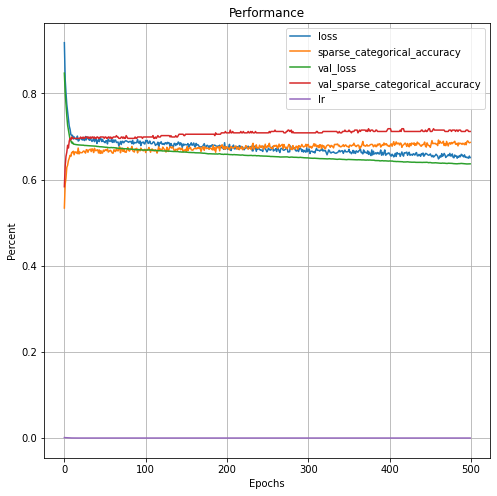

In [27]:
pd.DataFrame(history.history).plot(figsize=(8,8))
plt.grid(True)
#plt.gca().set_ylim(0,2)
plt.xlabel('Epochs')
plt.ylabel('Percent')
plt.title('Performance')
plt.show()